# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [12]:
import numpy as np
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

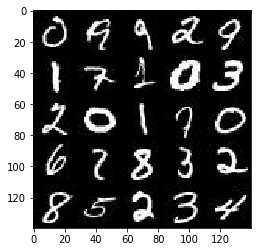

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

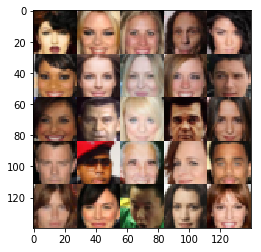

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [32]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    return (
        tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='input_real'),
        tf.placeholder(tf.float32, shape=(None, z_dim), name='input_z'),
        tf.placeholder(tf.float32, shape=(None), name='lr'),
    )

# Note, error is because of changes to how tf.assert_equal works in the test
# https://github.com/tensorflow/tensorflow/issues/11315

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>\n    app.launch_new_instance()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/carnd/anaconda3/envs/dl/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/carnd/anaconda3/envs/dl/

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
import tensorflow.contrib.layers as cl

def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    alpha = 0.1
    with tf.variable_scope('discriminator', reuse=reuse):
        # Conv 1
        x1 = tf.layers.conv2d(images, 64, 5, 2, 'SAME')
        x1relu = tf.maximum(alpha * x1, x1)
        
        # Conv 2
        x2 = tf.layers.conv2d(x1relu, 128, 5, 2, 'SAME')
        x2bn = tf.layers.batch_normalization(x2, training=True)
        x2relu = tf.maximum(alpha * x2bn, x2bn)
        
        # conv 3
        x3 = tf.layers.conv2d(x2relu, 256, 5, 2, 'SAME')
        x3bn = tf.layers.batch_normalization(x3, training=True)
        x3relu = tf.maximum(alpha * x3bn, x3bn)
        
        # fully-connected
        flat = tf.reshape(x3relu, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [29]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        x1 = tf.reshape(
            tf.layers.dense(z, 7*7*512),
            (-1, 7, 7, 512)
        )
        x1relu = tf.maximum(alpha * x1, x1)
        
        x3 = tf.layers.conv2d_transpose(x1relu, 128, 3, 1, 'SAME')
        x3bn = tf.layers.batch_normalization(x3, training=is_train)
        x3relu = tf.maximum(alpha * x3bn, x3bn)

        x4 = tf.layers.conv2d_transpose(x3relu, 64, 2, 2, 'SAME')
        x4bn = tf.layers.batch_normalization(x4, training=is_train)
        x4relu = tf.maximum(alpha * x4bn, x4bn)

        logits = tf.layers.conv2d_transpose(x4relu, out_channel_dim, 3, 2, 'SAME')
        out = tf.tanh(logits)
        
        return out
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=False if is_train==True else True):
        # Fully connected
        fc1 = tf.layers.dense(z, 7*7*512)
        fc1 = tf.reshape(fc1, (-1, 7, 7, 512))
        fc1 = tf.maximum(alpha*fc1, fc1)
        
        # Starting Conv Transpose Stack
        deconv2 = tf.layers.conv2d_transpose(fc1, 256, 3, 1, 'SAME')
        batch_norm2 = tf.layers.batch_normalization(deconv2, training=is_train)
        lrelu2 = tf.maximum(alpha * batch_norm2, batch_norm2)
        
        deconv3 = tf.layers.conv2d_transpose(lrelu2, 128, 3, 1, 'SAME')
        batch_norm3 = tf.layers.batch_normalization(deconv3, training=is_train)
        lrelu3 = tf.maximum(alpha * batch_norm3, batch_norm3)
        
        deconv4 = tf.layers.conv2d_transpose(lrelu3, 64, 3, 2, 'SAME')
        batch_norm4 = tf.layers.batch_normalization(deconv4, training=is_train)
        lrelu4 = tf.maximum(alpha * batch_norm4, batch_norm4)
        
        # Logits
        logits = tf.layers.conv2d_transpose(lrelu4, out_channel_dim, 3, 2, 'SAME')
        
        # Output
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    real_labels = tf.ones_like(d_real_out)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)
    
    smooth_d_real_out = tf.ones_like(d_real_logits) * np.random.uniform(0.7, 1.2)
    d_real_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_real_logits,
            labels=smooth_d_real_out,
        )
    )
    
    d_fake_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_fake_logits, 
            labels=tf.zeros_like(d_fake_out)
        )
    )

    d_loss = d_real_loss + d_fake_loss
        
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(
            logits=d_fake_logits, 
            labels=tf.ones_like(d_fake_out)
        )
    )


    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [43]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    d_filter = lambda v: v.name.startswith('discriminator')
    g_filter = lambda v: v.name.startswith('generator')
    
    vs = tf.trainable_variables()
    d_vs = list(filter(d_filter, vs))
    g_vs = list(filter(g_filter, vs))
    
    ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_ops = list(filter(d_filter, ops))
    g_ops = list(filter(g_filter, ops))
    
    with tf.control_dependencies(d_ops):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vs)

    with tf.control_dependencies(g_ops):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vs)
        
    return d_opt, g_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [44]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [47]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    step = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                # rescale from -.5 to .5 to -1 to 1, b/c g's final layer is tanh
                batch_images = batch_images * 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr: learning_rate})
                
                if step % 50 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print(
                        "Epoch {}/{}...".format(epoch_i + 1, epoch_count),
                        "Discriminator Loss: {:.4f}...".format(train_loss_d),
                        "Generator Loss: {:.4f}".format(train_loss_g)
                    )
                    
                if step % 150 == 0:
                    show_generator_output(sess, 10, input_z, image_channels, data_image_mode)
                
        print('Done!') 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 1.2452... Generator Loss: 1.0594
Epoch 1/2... Discriminator Loss: 1.0290... Generator Loss: 1.1909
Epoch 1/2... Discriminator Loss: 0.7980... Generator Loss: 1.8335


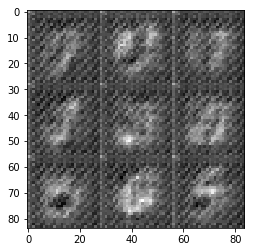

Epoch 1/2... Discriminator Loss: 0.8451... Generator Loss: 2.9138
Epoch 1/2... Discriminator Loss: 0.7992... Generator Loss: 1.9972
Epoch 1/2... Discriminator Loss: 0.8746... Generator Loss: 1.4041


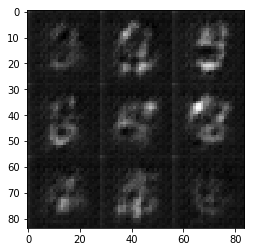

Epoch 1/2... Discriminator Loss: 2.2591... Generator Loss: 5.5290
Epoch 1/2... Discriminator Loss: 0.9597... Generator Loss: 1.2324
Epoch 1/2... Discriminator Loss: 0.8823... Generator Loss: 1.4634


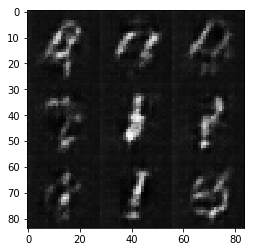

Epoch 1/2... Discriminator Loss: 0.9386... Generator Loss: 1.2513
Epoch 1/2... Discriminator Loss: 0.8777... Generator Loss: 1.5278
Epoch 1/2... Discriminator Loss: 0.9050... Generator Loss: 1.5534


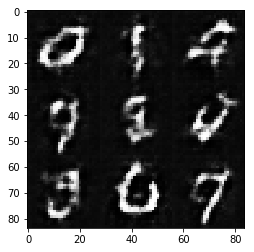

Epoch 1/2... Discriminator Loss: 1.5644... Generator Loss: 0.6666
Epoch 1/2... Discriminator Loss: 1.6181... Generator Loss: 3.0726
Epoch 1/2... Discriminator Loss: 1.1891... Generator Loss: 0.8460


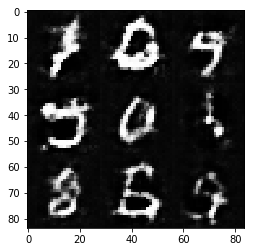

Epoch 1/2... Discriminator Loss: 1.0778... Generator Loss: 0.9672
Epoch 1/2... Discriminator Loss: 1.2897... Generator Loss: 2.2913
Epoch 1/2... Discriminator Loss: 1.2228... Generator Loss: 0.8478


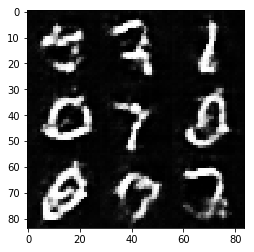

Epoch 1/2... Discriminator Loss: 1.1009... Generator Loss: 0.9486
Epoch 1/2... Discriminator Loss: 1.3085... Generator Loss: 2.0795
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 1.3668


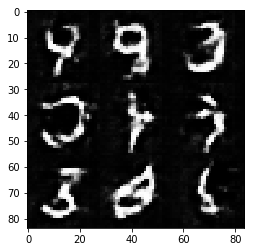

Epoch 1/2... Discriminator Loss: 0.9806... Generator Loss: 1.3362
Epoch 1/2... Discriminator Loss: 1.0997... Generator Loss: 1.1984
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 0.9107


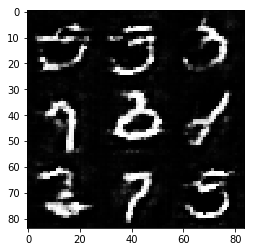

Epoch 1/2... Discriminator Loss: 0.9356... Generator Loss: 1.7032
Epoch 1/2... Discriminator Loss: 1.0493... Generator Loss: 1.2085
Epoch 1/2... Discriminator Loss: 1.2495... Generator Loss: 0.8178


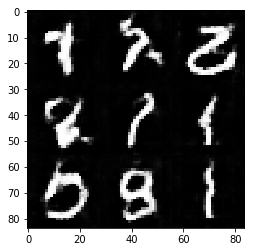

Epoch 1/2... Discriminator Loss: 1.5720... Generator Loss: 2.4817
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 1.3863
Epoch 1/2... Discriminator Loss: 2.1064... Generator Loss: 0.3851


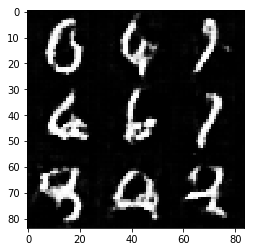

Epoch 1/2... Discriminator Loss: 1.0275... Generator Loss: 1.4277
Epoch 1/2... Discriminator Loss: 0.9226... Generator Loss: 1.3635
Epoch 1/2... Discriminator Loss: 1.1089... Generator Loss: 0.9592


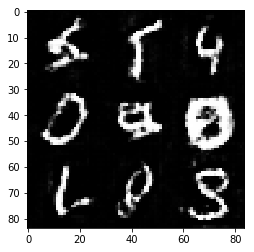

Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 0.6198
Epoch 1/2... Discriminator Loss: 1.0090... Generator Loss: 1.0936
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.4864


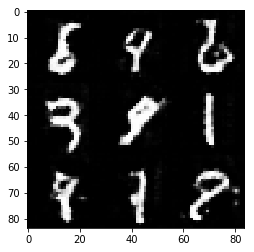

Epoch 1/2... Discriminator Loss: 0.9904... Generator Loss: 1.2667
Epoch 1/2... Discriminator Loss: 1.0488... Generator Loss: 1.0183
Epoch 1/2... Discriminator Loss: 1.4852... Generator Loss: 0.6299


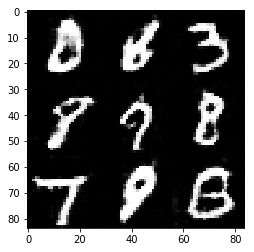

Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 1.0824
Epoch 1/2... Discriminator Loss: 1.6429... Generator Loss: 3.1622
Epoch 1/2... Discriminator Loss: 1.0157... Generator Loss: 1.2419


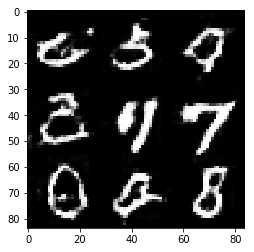

Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.2916
Epoch 1/2... Discriminator Loss: 1.7851... Generator Loss: 0.3990
Epoch 1/2... Discriminator Loss: 1.3421... Generator Loss: 0.7178


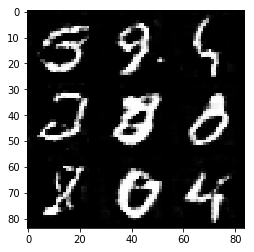

Epoch 1/2... Discriminator Loss: 1.2044... Generator Loss: 1.7694
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 1.3324
Epoch 1/2... Discriminator Loss: 0.9424... Generator Loss: 1.8504


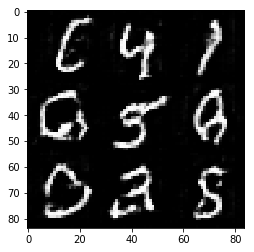

Epoch 1/2... Discriminator Loss: 0.9883... Generator Loss: 1.2246
Epoch 1/2... Discriminator Loss: 0.9208... Generator Loss: 1.4694
Epoch 1/2... Discriminator Loss: 1.0910... Generator Loss: 0.9773


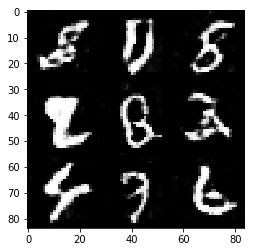

Epoch 1/2... Discriminator Loss: 0.9584... Generator Loss: 1.2518
Epoch 1/2... Discriminator Loss: 0.9811... Generator Loss: 1.1671
Epoch 1/2... Discriminator Loss: 1.2460... Generator Loss: 0.7603


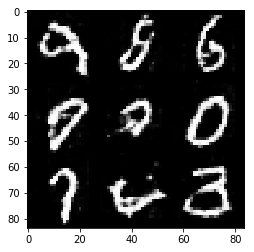

Epoch 1/2... Discriminator Loss: 0.8769... Generator Loss: 1.5734
Epoch 1/2... Discriminator Loss: 0.8162... Generator Loss: 1.8929
Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 1.3130


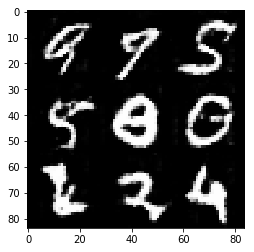

Epoch 1/2... Discriminator Loss: 1.0797... Generator Loss: 1.0531
Epoch 1/2... Discriminator Loss: 0.9768... Generator Loss: 1.1747
Epoch 1/2... Discriminator Loss: 0.7068... Generator Loss: 2.3237


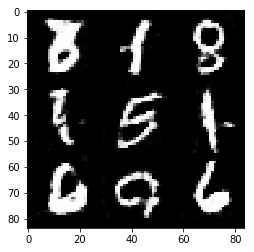

Epoch 2/2... Discriminator Loss: 1.1076... Generator Loss: 0.9811
Epoch 2/2... Discriminator Loss: 1.0066... Generator Loss: 1.1696
Epoch 2/2... Discriminator Loss: 1.1900... Generator Loss: 0.8602


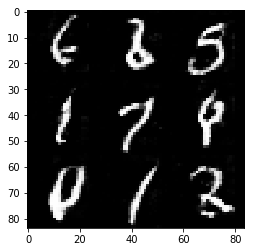

Epoch 2/2... Discriminator Loss: 0.9251... Generator Loss: 1.9786
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 0.8977
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.5826


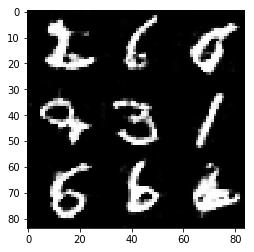

Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 0.8041
Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 1.1864
Epoch 2/2... Discriminator Loss: 1.4287... Generator Loss: 0.6369


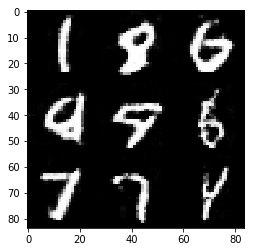

Epoch 2/2... Discriminator Loss: 0.8491... Generator Loss: 1.5953
Epoch 2/2... Discriminator Loss: 1.2237... Generator Loss: 0.8454
Epoch 2/2... Discriminator Loss: 0.8964... Generator Loss: 1.5187


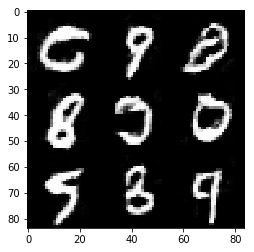

Epoch 2/2... Discriminator Loss: 0.9605... Generator Loss: 1.3194
Epoch 2/2... Discriminator Loss: 0.9326... Generator Loss: 1.3334
Epoch 2/2... Discriminator Loss: 0.8158... Generator Loss: 1.6901


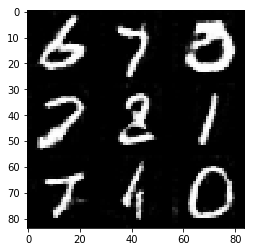

Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 2.3622
Epoch 2/2... Discriminator Loss: 1.2891... Generator Loss: 0.7526
Epoch 2/2... Discriminator Loss: 1.1513... Generator Loss: 0.9759


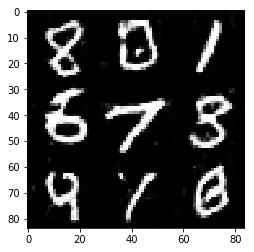

Epoch 2/2... Discriminator Loss: 1.2196... Generator Loss: 0.8683
Epoch 2/2... Discriminator Loss: 0.8705... Generator Loss: 1.9952
Epoch 2/2... Discriminator Loss: 1.1247... Generator Loss: 1.0261


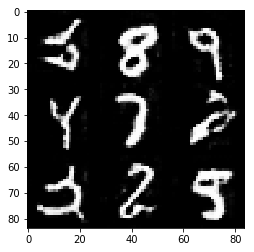

Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.5533
Epoch 2/2... Discriminator Loss: 0.8481... Generator Loss: 1.6458
Epoch 2/2... Discriminator Loss: 0.9834... Generator Loss: 1.2131


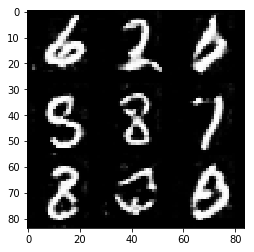

Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.8956
Epoch 2/2... Discriminator Loss: 0.8349... Generator Loss: 1.6931
Epoch 2/2... Discriminator Loss: 1.0406... Generator Loss: 1.0711


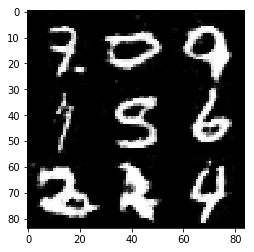

Epoch 2/2... Discriminator Loss: 0.9051... Generator Loss: 1.5728
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.9559
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 1.2322


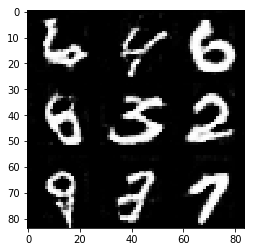

Epoch 2/2... Discriminator Loss: 1.3279... Generator Loss: 0.8658
Epoch 2/2... Discriminator Loss: 0.9242... Generator Loss: 1.4091
Epoch 2/2... Discriminator Loss: 1.1880... Generator Loss: 0.8878


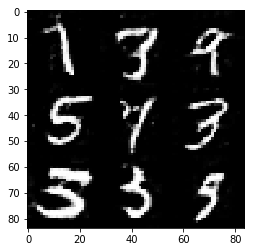

Epoch 2/2... Discriminator Loss: 1.4102... Generator Loss: 0.7615
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 1.1322
Epoch 2/2... Discriminator Loss: 0.9097... Generator Loss: 1.2951


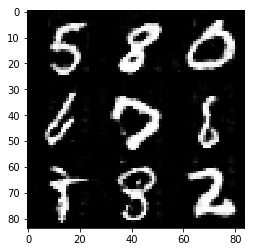

Epoch 2/2... Discriminator Loss: 0.9024... Generator Loss: 1.5900
Epoch 2/2... Discriminator Loss: 1.0779... Generator Loss: 1.0168
Epoch 2/2... Discriminator Loss: 1.0186... Generator Loss: 1.1862


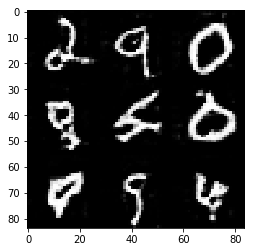

Epoch 2/2... Discriminator Loss: 0.8660... Generator Loss: 1.4954
Epoch 2/2... Discriminator Loss: 0.8092... Generator Loss: 1.7013
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 1.3371


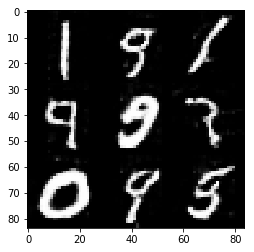

Epoch 2/2... Discriminator Loss: 0.7725... Generator Loss: 1.7799
Epoch 2/2... Discriminator Loss: 1.1519... Generator Loss: 0.9047
Epoch 2/2... Discriminator Loss: 1.1067... Generator Loss: 0.9515


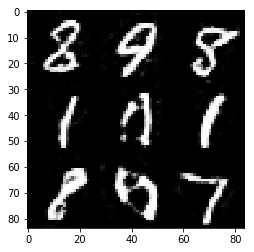

Epoch 2/2... Discriminator Loss: 0.9278... Generator Loss: 1.7521
Epoch 2/2... Discriminator Loss: 0.9195... Generator Loss: 1.9850
Epoch 2/2... Discriminator Loss: 0.8208... Generator Loss: 2.1215


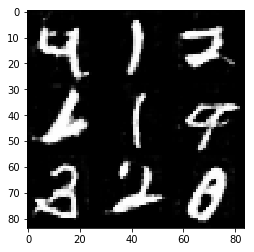

Epoch 2/2... Discriminator Loss: 0.8599... Generator Loss: 1.5004
Epoch 2/2... Discriminator Loss: 0.9230... Generator Loss: 1.3488
Epoch 2/2... Discriminator Loss: 0.9947... Generator Loss: 1.4106


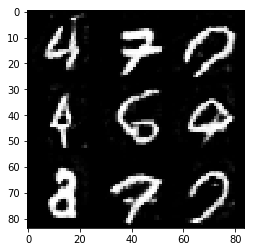

Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.4588
Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 2.4355
Epoch 2/2... Discriminator Loss: 1.0576... Generator Loss: 1.2238


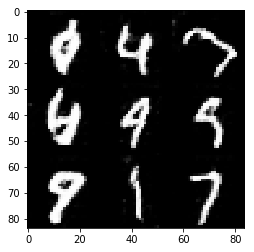

Epoch 2/2... Discriminator Loss: 0.7531... Generator Loss: 1.9180
Epoch 2/2... Discriminator Loss: 0.8268... Generator Loss: 2.6706
Epoch 2/2... Discriminator Loss: 0.8168... Generator Loss: 1.6025


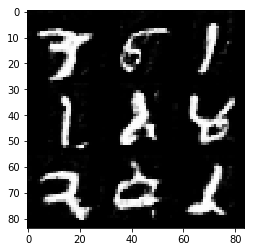

Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 1.4103
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 1.3847
Epoch 2/2... Discriminator Loss: 0.6803... Generator Loss: 2.6069


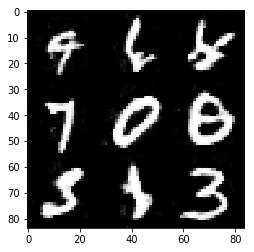

Done!


In [48]:
batch_size = 20
z_dim = 50
learning_rate = 0.0002
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.7242
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.8007
Epoch 1/1... Discriminator Loss: 1.5669... Generator Loss: 0.4587


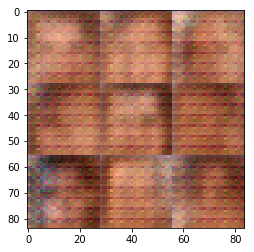

Epoch 1/1... Discriminator Loss: 1.1961... Generator Loss: 1.2033
Epoch 1/1... Discriminator Loss: 2.2698... Generator Loss: 0.2166
Epoch 1/1... Discriminator Loss: 1.2614... Generator Loss: 1.1520


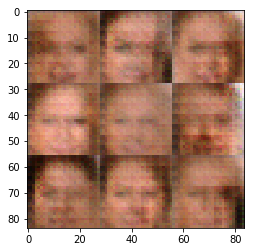

Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.6742... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.0367... Generator Loss: 1.2291


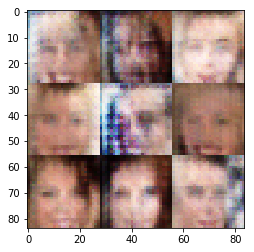

Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 1.2770
Epoch 1/1... Discriminator Loss: 1.1865... Generator Loss: 1.0581
Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 1.0463


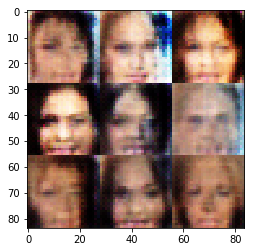

Epoch 1/1... Discriminator Loss: 1.3735... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.9198... Generator Loss: 0.2987
Epoch 1/1... Discriminator Loss: 1.4598... Generator Loss: 0.7724


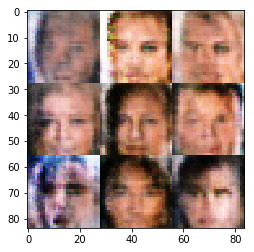

Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 1.0504
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.8874
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.8334


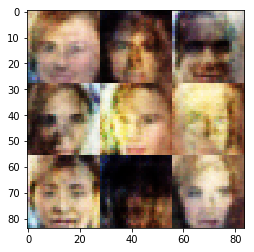

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9306
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.0701
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.7479


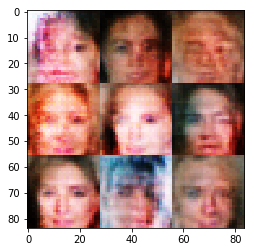

Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.7412
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.9628
Epoch 1/1... Discriminator Loss: 1.7919... Generator Loss: 0.3535


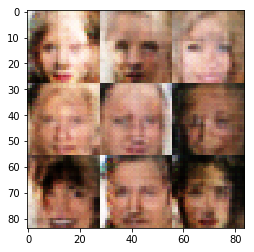

Epoch 1/1... Discriminator Loss: 1.2386... Generator Loss: 0.9605
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 1.1796


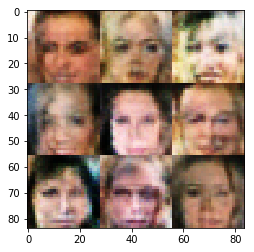

Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6293
Epoch 1/1... Discriminator Loss: 1.5011... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8096


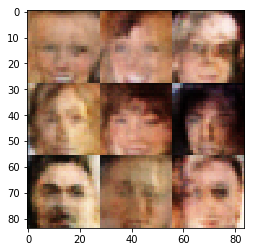

Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 1.2648
Epoch 1/1... Discriminator Loss: 1.2964... Generator Loss: 0.6898


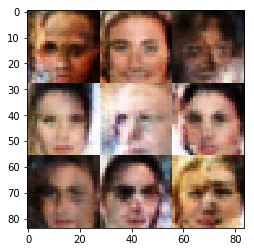

Epoch 1/1... Discriminator Loss: 1.2172... Generator Loss: 1.0003
Epoch 1/1... Discriminator Loss: 1.4457... Generator Loss: 0.5722
Epoch 1/1... Discriminator Loss: 1.4349... Generator Loss: 0.6371


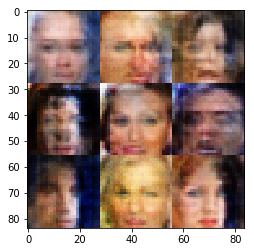

Epoch 1/1... Discriminator Loss: 1.1279... Generator Loss: 1.0030
Epoch 1/1... Discriminator Loss: 1.2517... Generator Loss: 0.8914
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5794


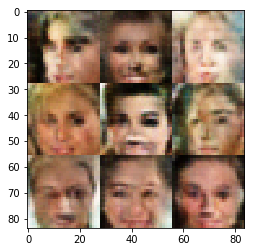

Epoch 1/1... Discriminator Loss: 1.6804... Generator Loss: 0.4472
Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 1.3700
Epoch 1/1... Discriminator Loss: 1.1801... Generator Loss: 0.9814


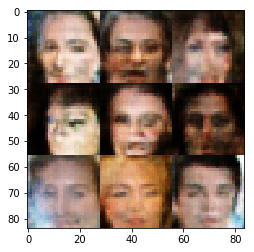

Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.4264
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7535


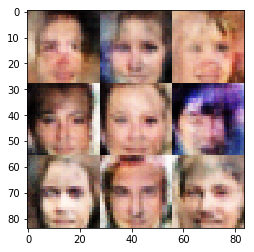

Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.1280... Generator Loss: 1.1595
Epoch 1/1... Discriminator Loss: 1.1797... Generator Loss: 1.0149


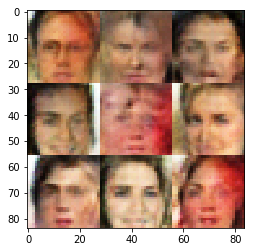

Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.3447
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.5465
Epoch 1/1... Discriminator Loss: 1.1115... Generator Loss: 1.0764


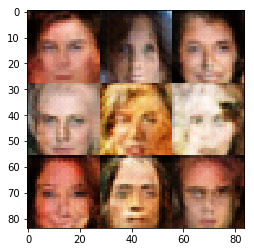

Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.9034
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6997


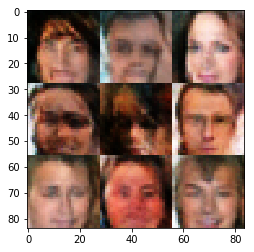

Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.7509
Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.6485


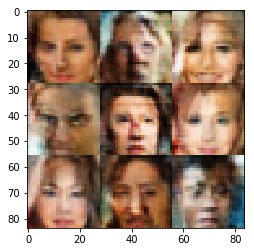

Epoch 1/1... Discriminator Loss: 1.2960... Generator Loss: 0.6724
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.4988... Generator Loss: 0.7177


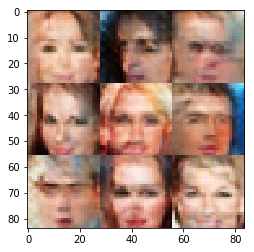

Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.2755... Generator Loss: 1.1276
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7825


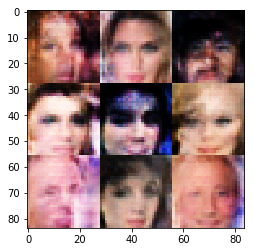

Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.6211
Epoch 1/1... Discriminator Loss: 1.3145... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.0924... Generator Loss: 1.0366


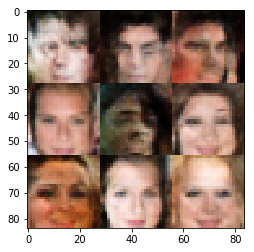

Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 0.9675
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.2270... Generator Loss: 0.7638


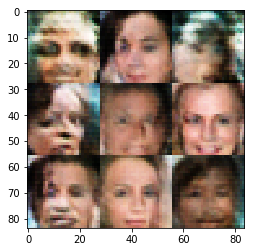

Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.6046... Generator Loss: 0.5330
Epoch 1/1... Discriminator Loss: 1.2164... Generator Loss: 0.7398


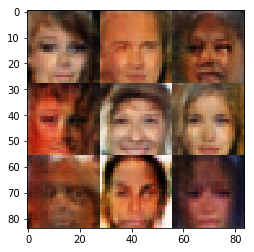

Epoch 1/1... Discriminator Loss: 1.5675... Generator Loss: 0.5982
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 1.0707


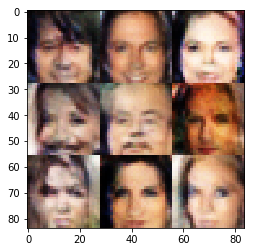

Epoch 1/1... Discriminator Loss: 1.0494... Generator Loss: 1.1751
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.2642... Generator Loss: 1.0461


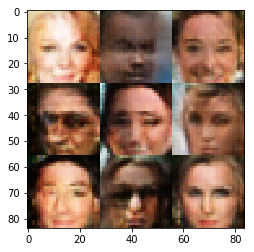

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.9194
Epoch 1/1... Discriminator Loss: 1.0837... Generator Loss: 1.1959
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.9214


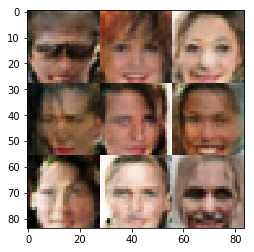

Epoch 1/1... Discriminator Loss: 1.1386... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 1.0799... Generator Loss: 1.4030


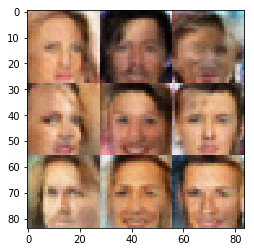

Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.1476... Generator Loss: 1.0879
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.8916


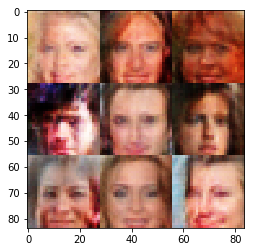

Epoch 1/1... Discriminator Loss: 1.0917... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7062
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.7651


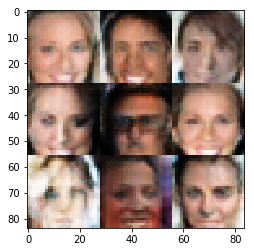

Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.2705... Generator Loss: 0.6824


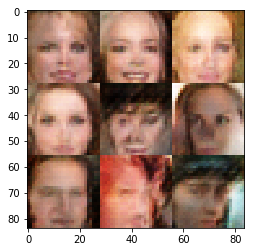

Epoch 1/1... Discriminator Loss: 1.0493... Generator Loss: 1.0583
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.6574
Epoch 1/1... Discriminator Loss: 1.1993... Generator Loss: 0.7934


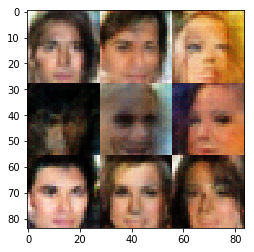

Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.8363
Epoch 1/1... Discriminator Loss: 0.8629... Generator Loss: 1.3022
Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.7710


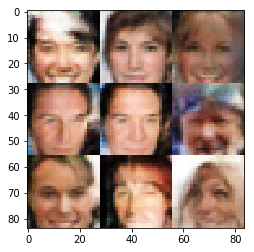

Epoch 1/1... Discriminator Loss: 1.4090... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.1277... Generator Loss: 0.8761


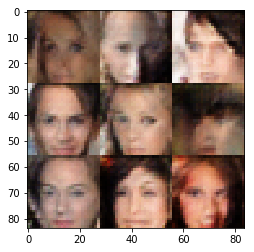

Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.7354
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.9258


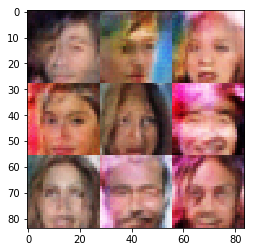

Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.6535


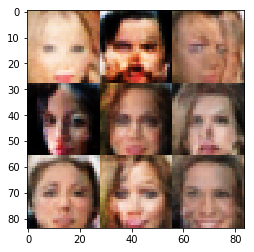

Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 1.0293
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.8088
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8002


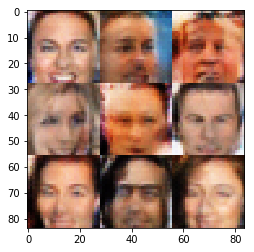

Epoch 1/1... Discriminator Loss: 1.3851... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6925
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.0309


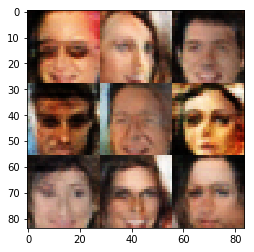

Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8582
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.6395


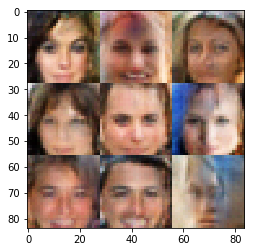

Epoch 1/1... Discriminator Loss: 1.3426... Generator Loss: 0.8036
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.3373... Generator Loss: 0.6043


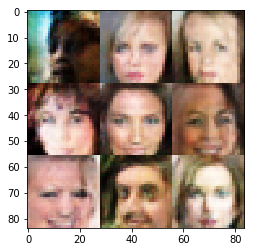

Epoch 1/1... Discriminator Loss: 1.2453... Generator Loss: 0.6798
Epoch 1/1... Discriminator Loss: 1.4933... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.5606


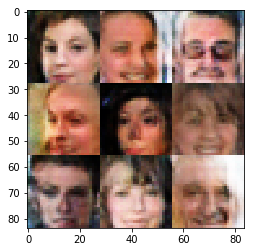

Epoch 1/1... Discriminator Loss: 1.5360... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.6490
Epoch 1/1... Discriminator Loss: 1.6357... Generator Loss: 0.4910


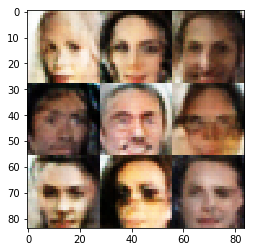

Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.2615... Generator Loss: 0.7645


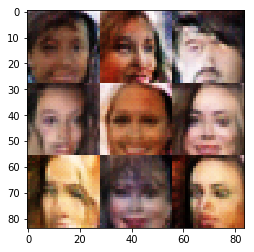

Epoch 1/1... Discriminator Loss: 1.1301... Generator Loss: 1.0935
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.8305


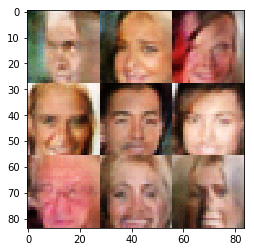

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.2930... Generator Loss: 0.7190
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 0.8493


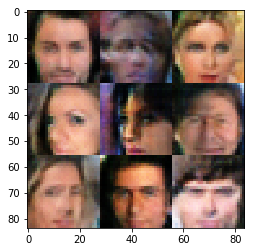

Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.0673... Generator Loss: 1.1811
Epoch 1/1... Discriminator Loss: 1.2652... Generator Loss: 0.7411


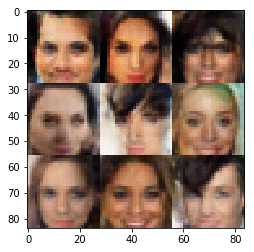

Epoch 1/1... Discriminator Loss: 1.3270... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.1505... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.9406


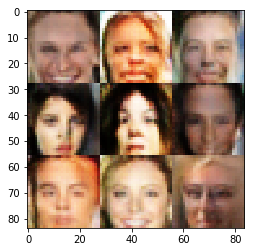

Epoch 1/1... Discriminator Loss: 1.4647... Generator Loss: 0.5061
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.7073
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.6380


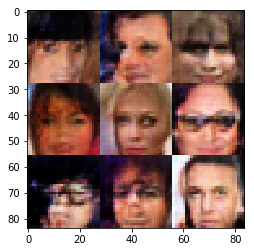

Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.1767... Generator Loss: 0.8855
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.4915


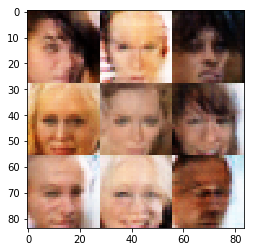

Epoch 1/1... Discriminator Loss: 1.1473... Generator Loss: 1.0579
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.1268... Generator Loss: 0.8605


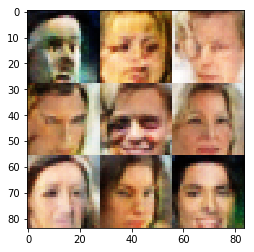

Epoch 1/1... Discriminator Loss: 1.5414... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5830


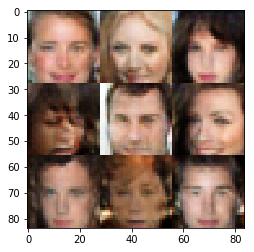

Epoch 1/1... Discriminator Loss: 1.1484... Generator Loss: 0.9250
Epoch 1/1... Discriminator Loss: 1.1209... Generator Loss: 1.1405
Epoch 1/1... Discriminator Loss: 1.1502... Generator Loss: 1.0070


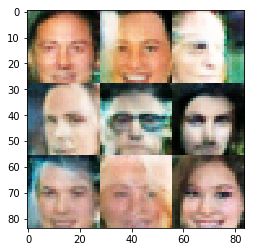

Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.5804
Epoch 1/1... Discriminator Loss: 0.9929... Generator Loss: 1.4029
Epoch 1/1... Discriminator Loss: 1.0411... Generator Loss: 1.1688


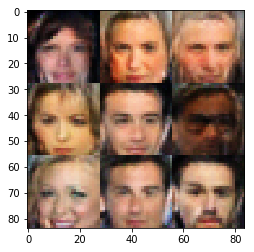

Epoch 1/1... Discriminator Loss: 1.1192... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 1.1514... Generator Loss: 1.3583
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.8635


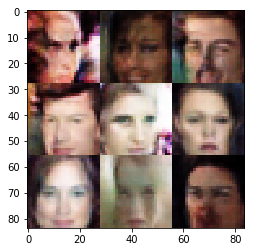

Epoch 1/1... Discriminator Loss: 1.1644... Generator Loss: 0.8241
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9058
Epoch 1/1... Discriminator Loss: 0.9876... Generator Loss: 1.0067


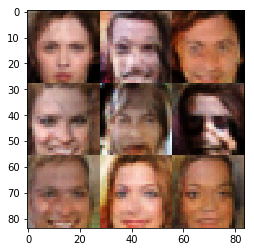

Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2546... Generator Loss: 0.7942


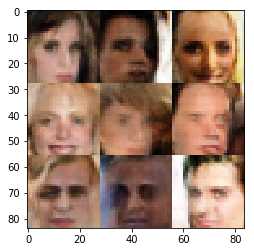

Epoch 1/1... Discriminator Loss: 1.0931... Generator Loss: 0.9447
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.8389
Epoch 1/1... Discriminator Loss: 1.0813... Generator Loss: 0.9586


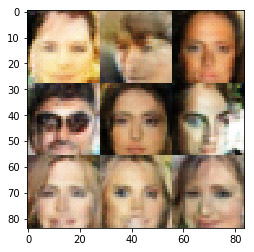

Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.6851
Epoch 1/1... Discriminator Loss: 1.1515... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.2238... Generator Loss: 0.8657


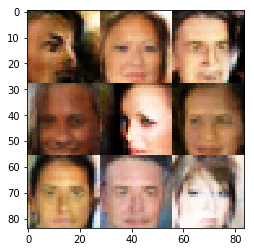

Epoch 1/1... Discriminator Loss: 1.2613... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.1587... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.1798... Generator Loss: 0.8959


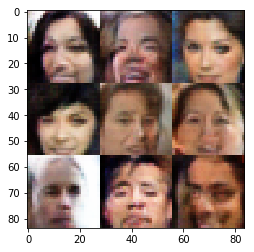

Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.4561... Generator Loss: 0.6829
Epoch 1/1... Discriminator Loss: 1.1756... Generator Loss: 0.8958


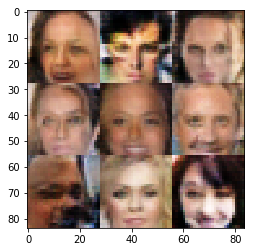

Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.2396... Generator Loss: 1.1651
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6591


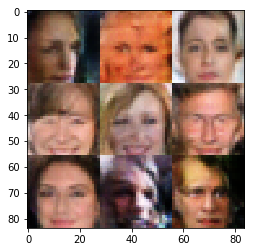

Epoch 1/1... Discriminator Loss: 1.1643... Generator Loss: 0.9378
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.6840
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 1.0449


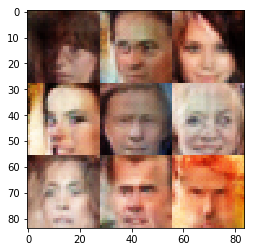

Epoch 1/1... Discriminator Loss: 1.3197... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.2594... Generator Loss: 0.7089
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.6986


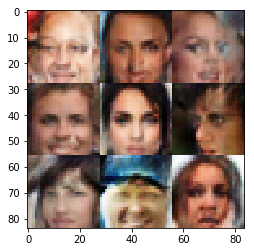

Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6789
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.5543


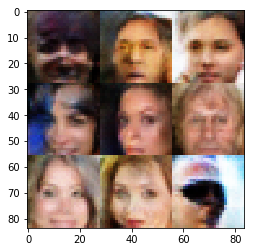

Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 0.8826
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 1.1719
Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.5588


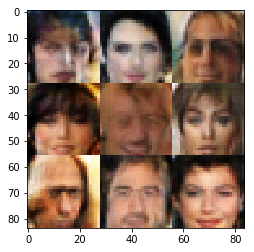

Epoch 1/1... Discriminator Loss: 1.2433... Generator Loss: 0.7049
Epoch 1/1... Discriminator Loss: 1.2655... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.2601... Generator Loss: 0.7756


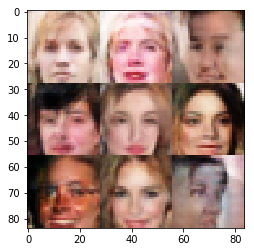

Epoch 1/1... Discriminator Loss: 0.8865... Generator Loss: 1.3736
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6196
Epoch 1/1... Discriminator Loss: 1.2807... Generator Loss: 0.7566


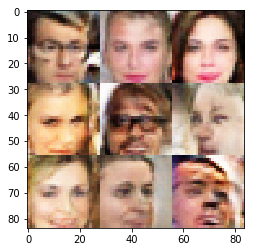

Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.6278
Done!


In [49]:
batch_size = 20
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.